In [1]:
import sys
sys.path.append('..')

In [30]:
import numpy as np
import ceviche_challenges
from ceviche_challenges import units as u
import ceviche
from ceviche import viz
from inverse_design.brushes import notched_square_brush, circular_brush
from inverse_design.conditional_generator import (
    new_latent_design, transform
)
from tqdm.notebook import trange

import autograd
import autograd.numpy as npa

from skimage.morphology import dilation, erosion

In [3]:
import jax
import jax.numpy as jnp
from javiche import jaxit
import matplotlib.pylab as plt
import matplotlib as mpl
import numpy as np
from inverse_design.conditional_generator import generate_feasible_design_mask
from jax.example_libraries.optimizers import adam
import time

# Global flag to set a specific platform, must be used at startup.
jax.config.update('jax_platform_name', 'cpu')

In [34]:
spec = ceviche_challenges.waveguide_bend.prefabs.waveguide_bend_2umx2um_spec(
  wg_width=400*u.nm, variable_region_size=(1600*u.nm, 1600*u.nm), cladding_permittivity=2.25 #(1600*u.nm, 1600*u.nm)
)
#params = ceviche_challenges.waveguide_bend.prefabs.waveguide_bend_sim_params(resolution = 25 * u.nm, wavelengths = np.arange(1260, 1290, 10)*u.nm) #, np.arange(1260, 1300, 10)*u.nm
params = ceviche_challenges.waveguide_bend.prefabs.waveguide_bend_sim_params(resolution = 10 * u.nm, wavelengths=u.Array([1270, 1280, 1290], u.nm))
model = ceviche_challenges.waveguide_bend.model.WaveguideBendModel(params, spec)

In [35]:
brush = circular_brush(11)
latent = new_latent_design(model.design_variable_shape, bias=0.01, r=3, r_scale=0.005)

In [36]:
def forward(latent_weights, brush, progress):
    latent_t = transform(latent_weights, brush, 5)
    design_mask = generate_feasible_design_mask(latent_t, 
      brush) #, verbose=False
    design = (design_mask+1.0)/2.0
    return design

In [50]:
def plot_state(model, rho, grads, step):
    rho = erosion(dilation(rho, brush), brush)
    des = forward(rho, brush, step/ Nsteps)
    
    _, E_12 = model.simulate(des, excite_port_idxs=[0])
    _, E_21 = model.simulate(des, excite_port_idxs=[1])

    E_12 = E_12[1].squeeze()
    E_21 = E_21[1].squeeze()
    
    fig, ax = plt.subplots(1,5, figsize=(5*4,4))
    viz.abs(E_12, outline=model.density(des), ax=ax[0]);
    viz.abs(E_21, outline=model.density(des), ax=ax[1]);
    viz.real(grads, ax=ax[2]);
    ax[3].imshow(grads.T)
    plt.show()

In [51]:
@jaxit(cache=False)
def inner_loss_fn(design):
    s_params, fields = model.simulate(design)
    return s_params

def loss_fn(latent, step):
#def loss_fn(latent):
    design = forward(latent, brush, step/Nsteps)
    #design = forward(latent, brush)
    s_params = inner_loss_fn(design)

    s11 = jnp.abs(s_params[:, 0, 0])**2
    s21 = jnp.abs(s_params[:, 0, 1])**2


    s = jnp.stack((s11,s21)).flatten()
    g = jnp.stack((jnp.ones_like(s11),-jnp.ones_like(s21))).flatten()

    t_s21 = 10**(-0.5/20)
    t_s11 = 10**(-20/20)

    target = jnp.stack((jnp.ones_like(s11)*(t_s11**2),jnp.ones_like(s21)*(t_s21**2))).flatten()
    w_min = min(1-t_s21, t_s11)
    L = jnp.sum( jax.nn.softplus(g*(s-target)/w_min)**2 )
    return L

In [52]:
grad_fn = jax.grad(loss_fn)

step_size = 0.01
init_fn, update_fn, params_fn = adam(step_size, b1=0.667, b2=0.9)
state = init_fn(latent)

debug_latent = True
debug_grad = True
def step_fn(step, state):
    latent = params_fn(state)

    loss = loss_fn(latent, step)
    grads = grad_fn(latent, step)

    optim_state = update_fn(step, grads, state)

    if debug:
        plot_state(model, latent, grads, step)
        print("Step :", step+1, '/', Nsteps)
        print("Loss :", loss)
        print("Max grad:", np.max(grads))
    
    return loss, optim_state

In [53]:
def step_fnn(step, state):
    latent = params_fn(state) # we need autograd arrays here...
    grads = grad_fn(latent)
    loss = loss_fn(latent)

    optim_state = update_fn(step, grads, state)

    if debug:
        plot_state(model, latent, grads)
        print("Step :", step+1, '/', Nsteps)
        print("Loss :", loss)
        print("Max grad:", np.max(grads))
    
    return loss, optim_state
     

  0%|          | 0/20 [00:00<?, ?it/s]

True


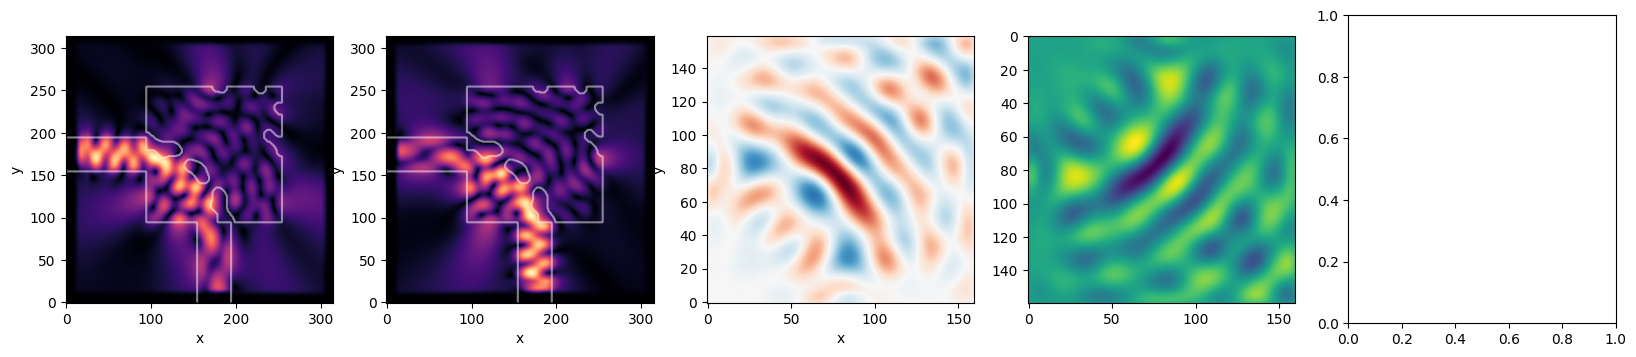

Step : 1 / 20
Loss : 166.04489
Max grad: 0.91899514
True


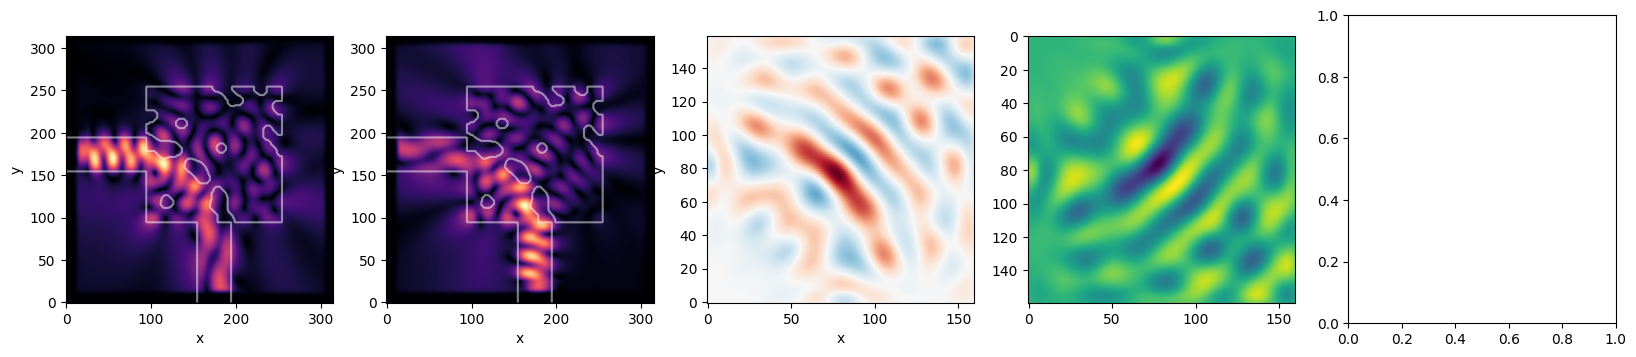

Step : 2 / 20
Loss : 169.1925
Max grad: 0.43167275
True


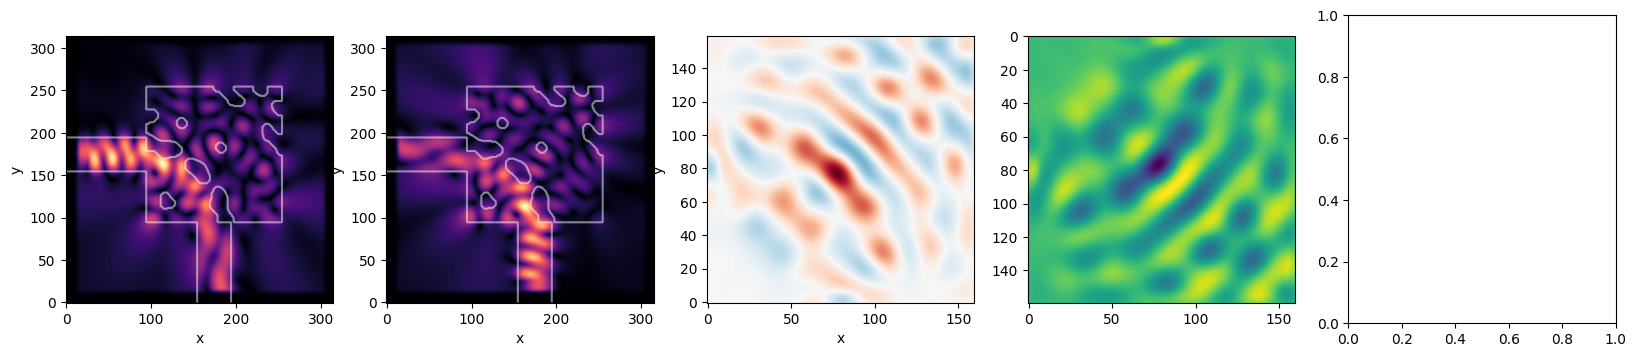

Step : 3 / 20
Loss : 168.94965
Max grad: 0.251056
True


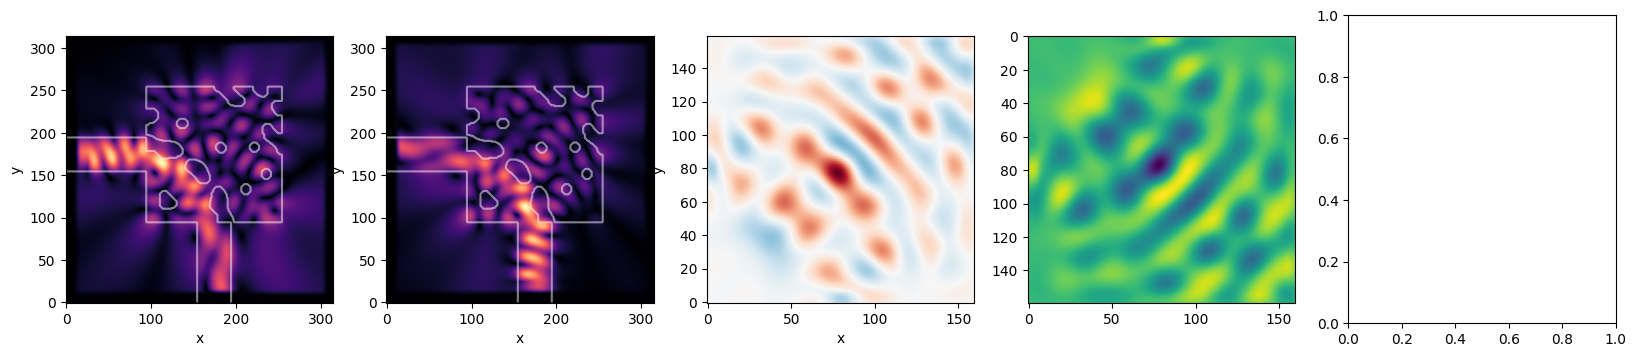

Step : 4 / 20
Loss : 212.4874
Max grad: 0.16420524
True


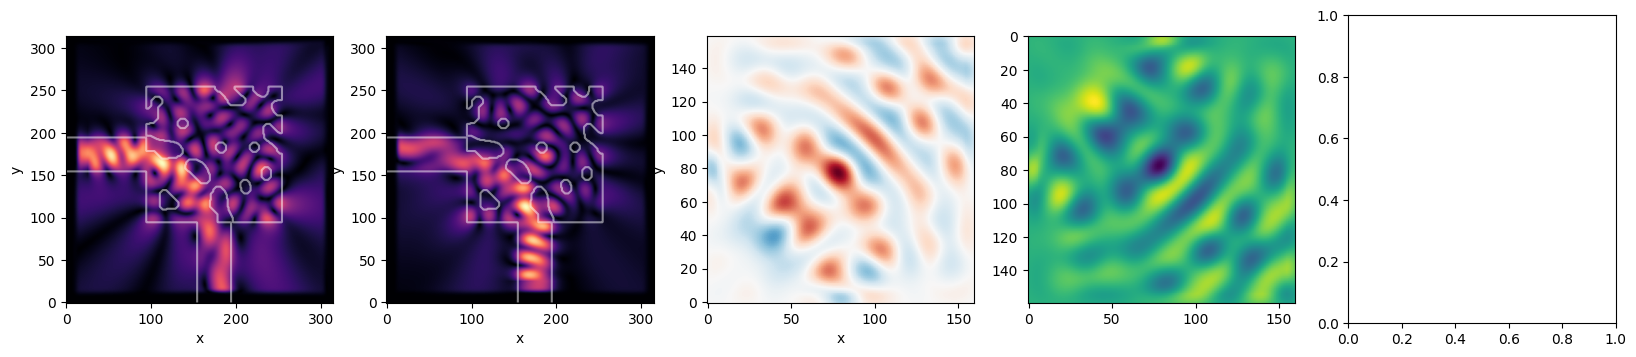

Step : 5 / 20
Loss : 166.64987
Max grad: 0.13346636
True


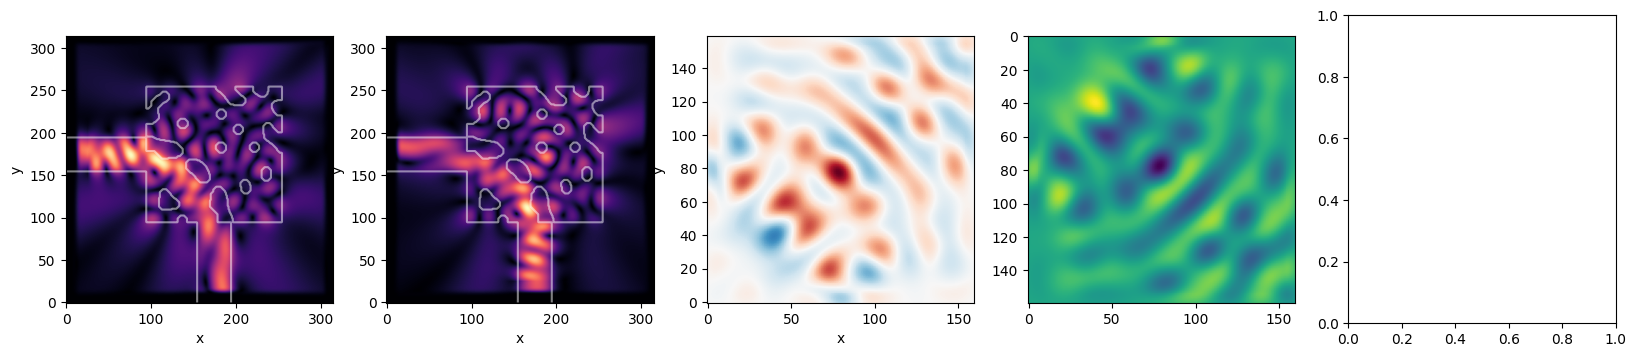

Step : 6 / 20
Loss : 76.46587
Max grad: 0.11394584
True


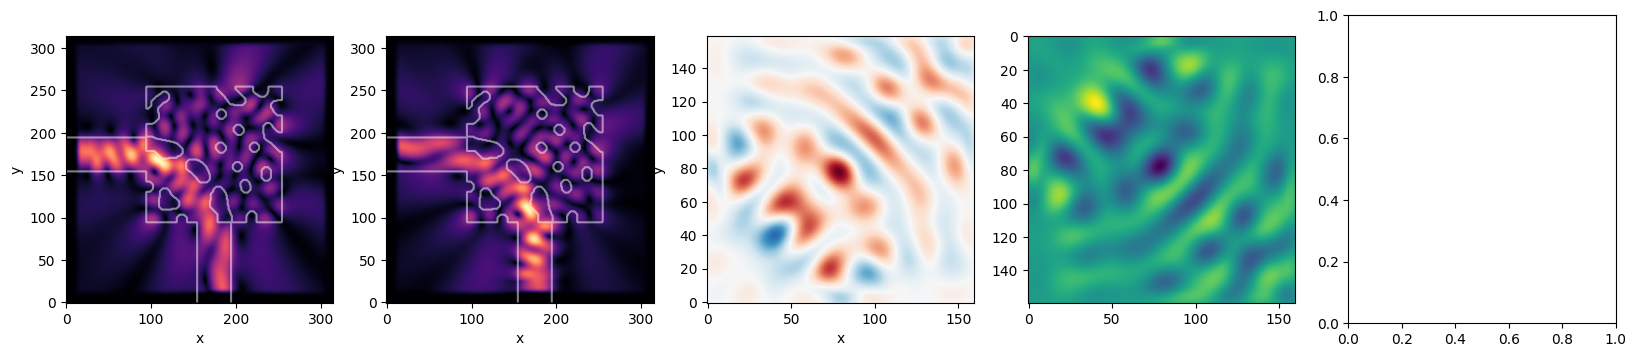

Step : 7 / 20
Loss : 57.341675
Max grad: 0.09299448
True


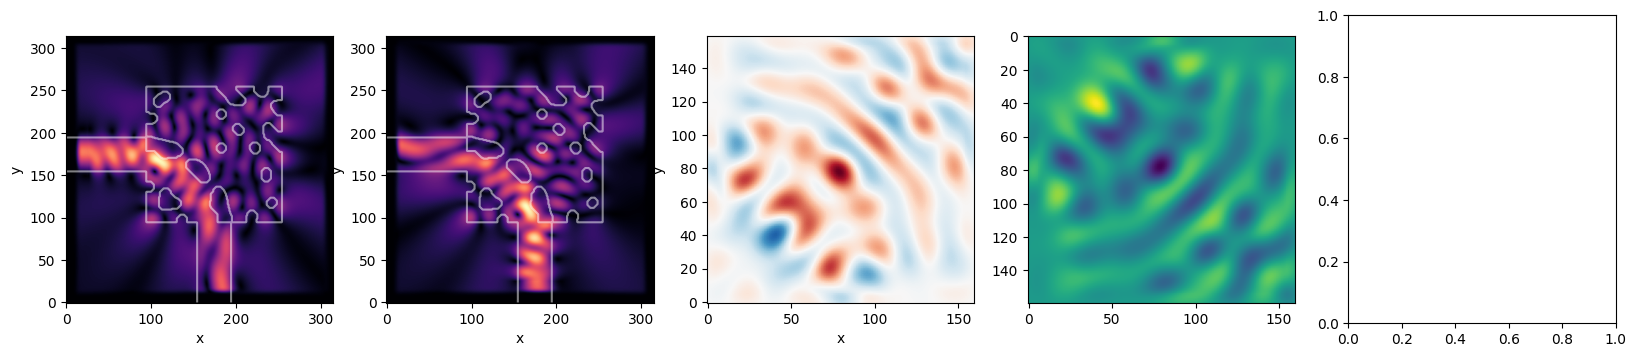

Step : 8 / 20
Loss : 63.911312
Max grad: 0.07363731
True


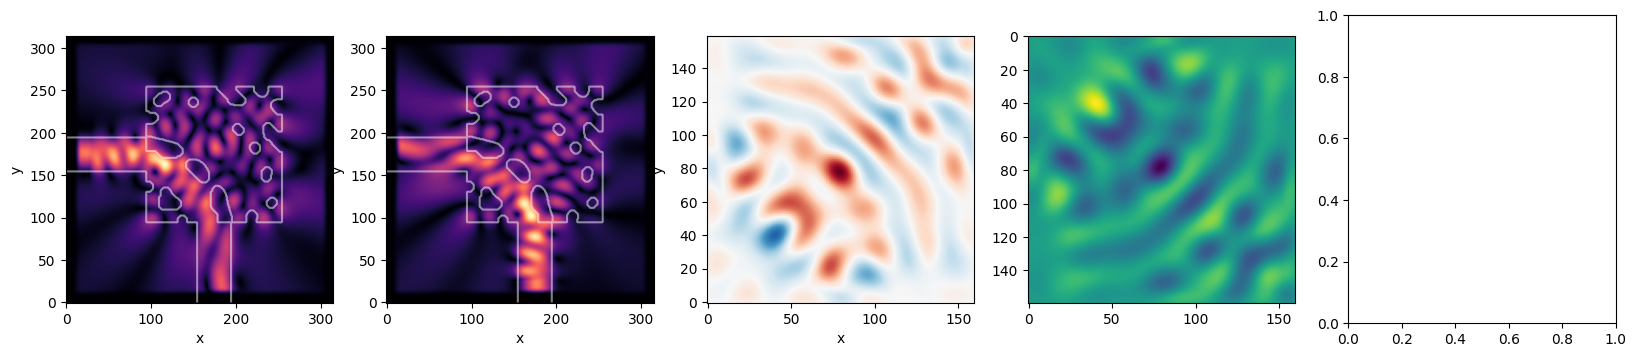

Step : 9 / 20
Loss : 71.90437
Max grad: 0.0574346
True


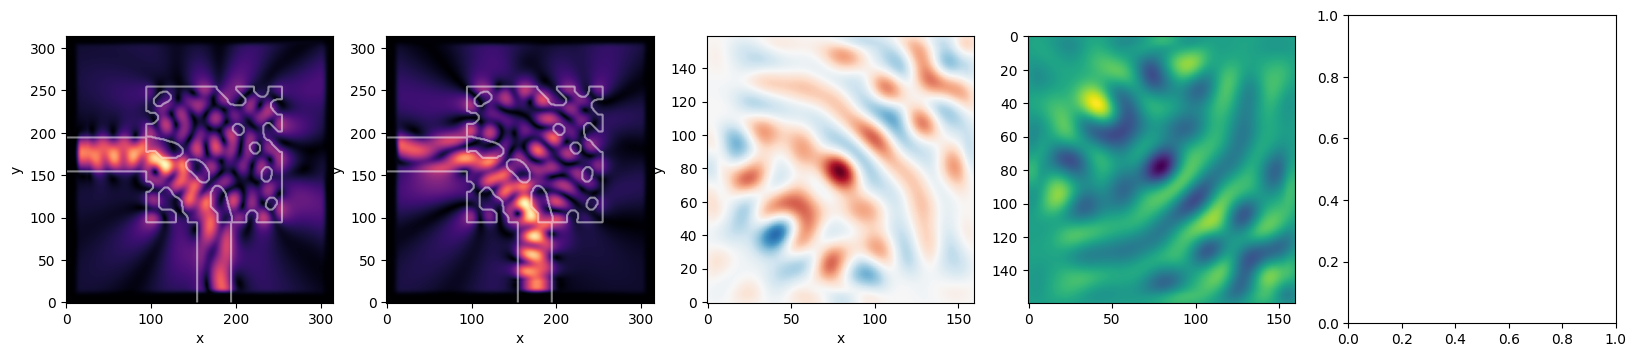

Step : 10 / 20
Loss : 65.55268
Max grad: 0.04451947
True


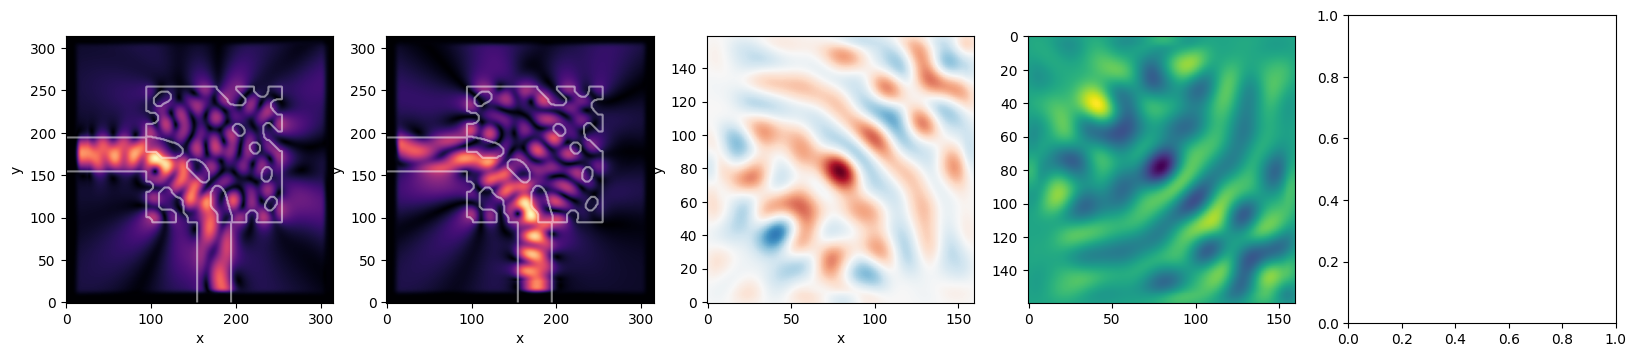

Step : 11 / 20
Loss : 56.61032
Max grad: 0.034467857
True


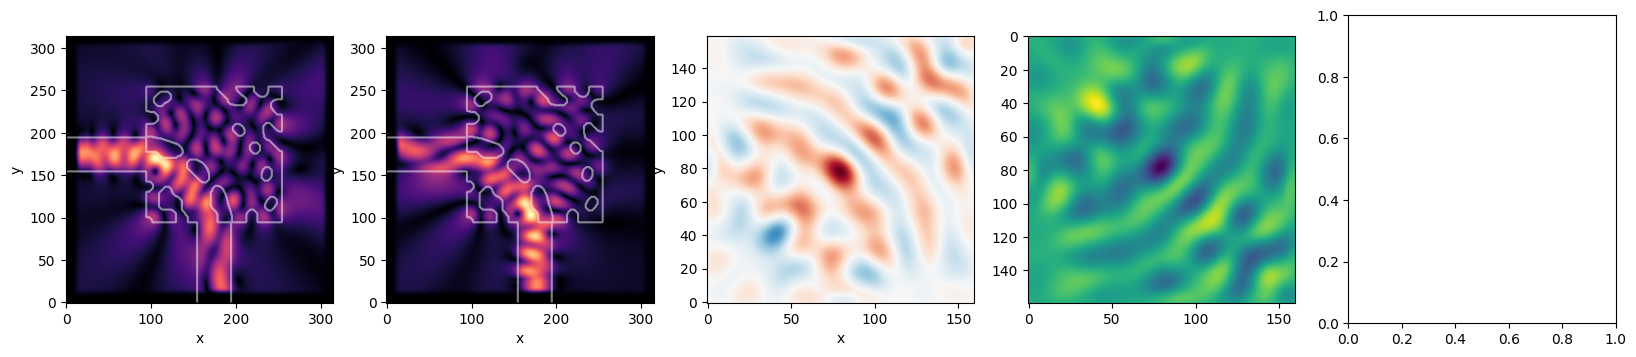

Step : 12 / 20
Loss : 61.709694
Max grad: 0.026734546
True


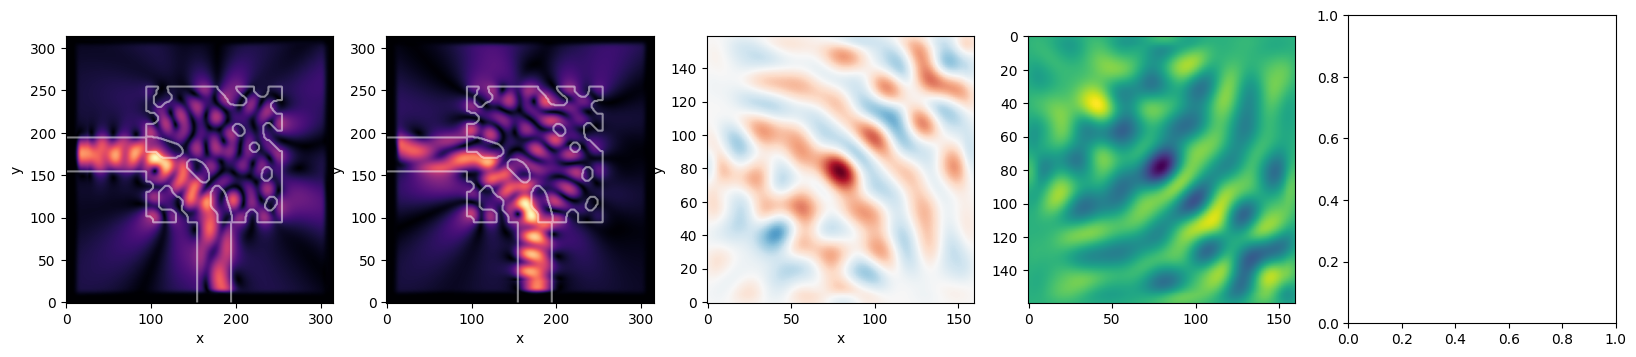

Step : 13 / 20
Loss : 60.891823
Max grad: 0.020826
True


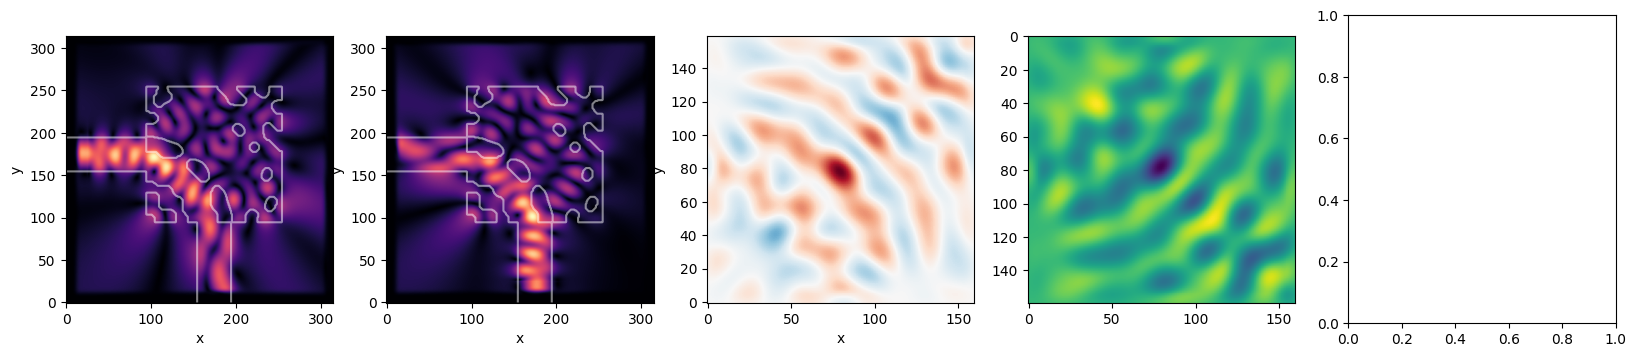

Step : 14 / 20
Loss : 44.61402
Max grad: 0.016354233
True


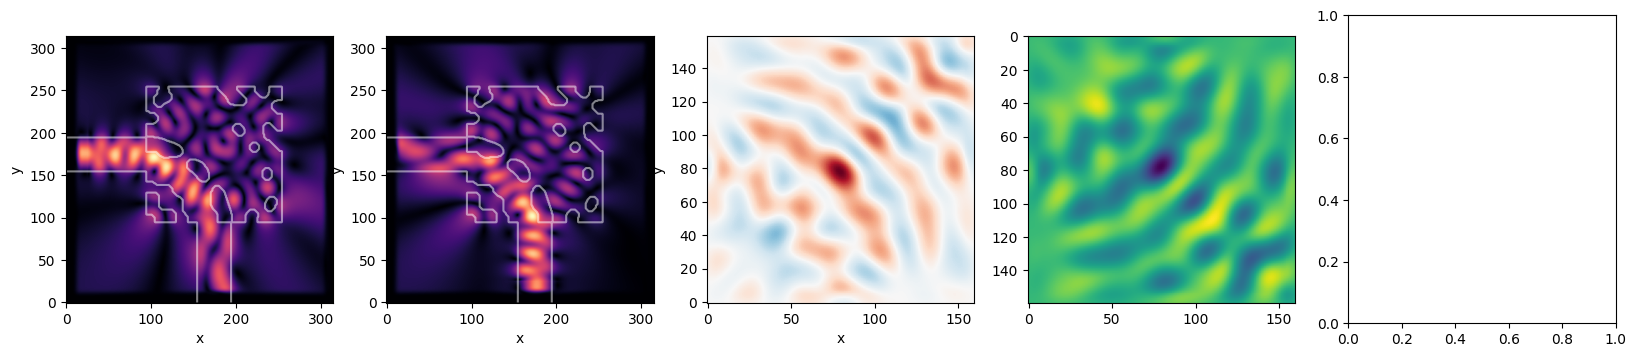

Step : 15 / 20
Loss : 44.54727
Max grad: 0.014318256
True


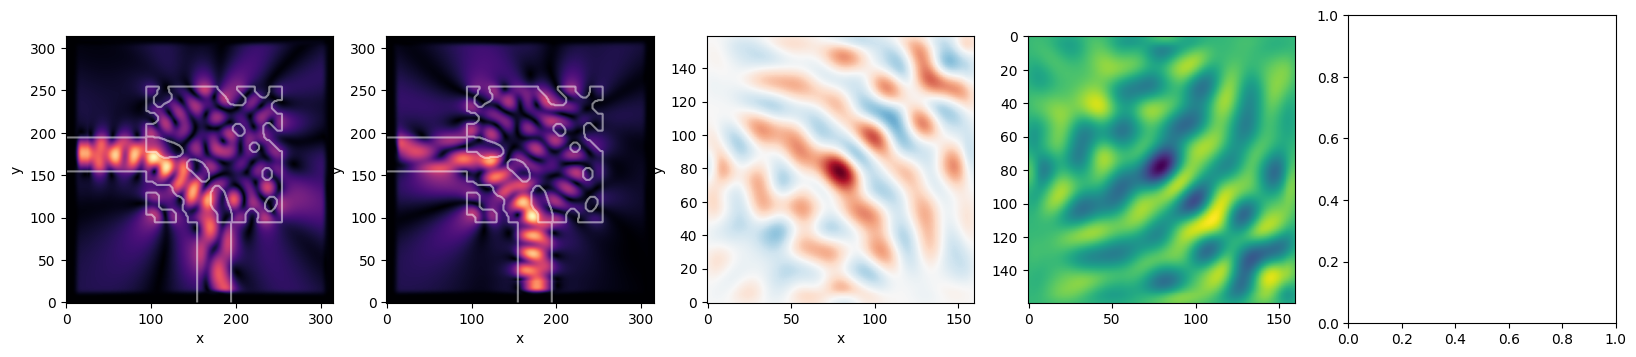

Step : 16 / 20
Loss : 31.556557
Max grad: 0.01298805
True


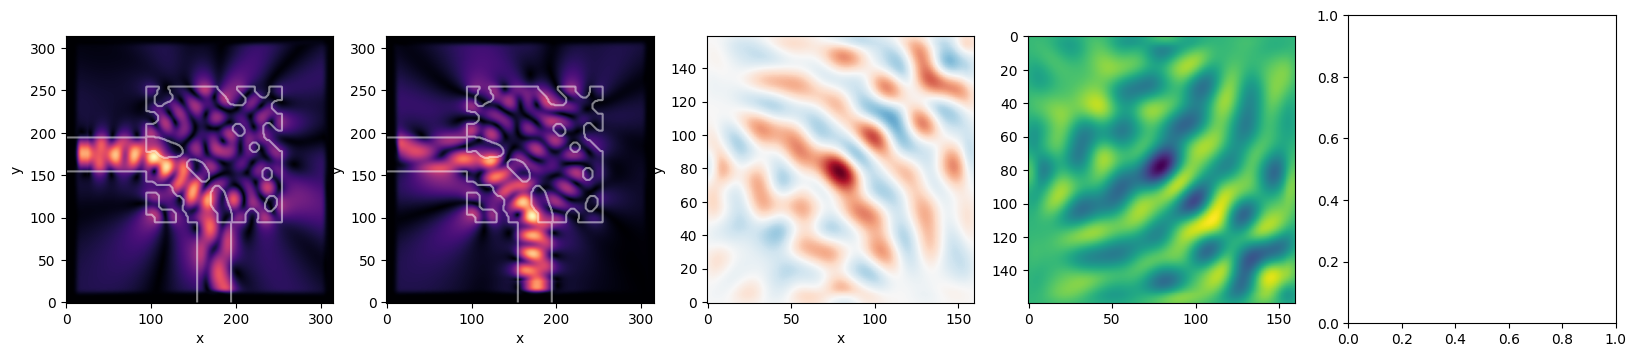

Step : 17 / 20
Loss : 28.000557
Max grad: 0.011898324
True


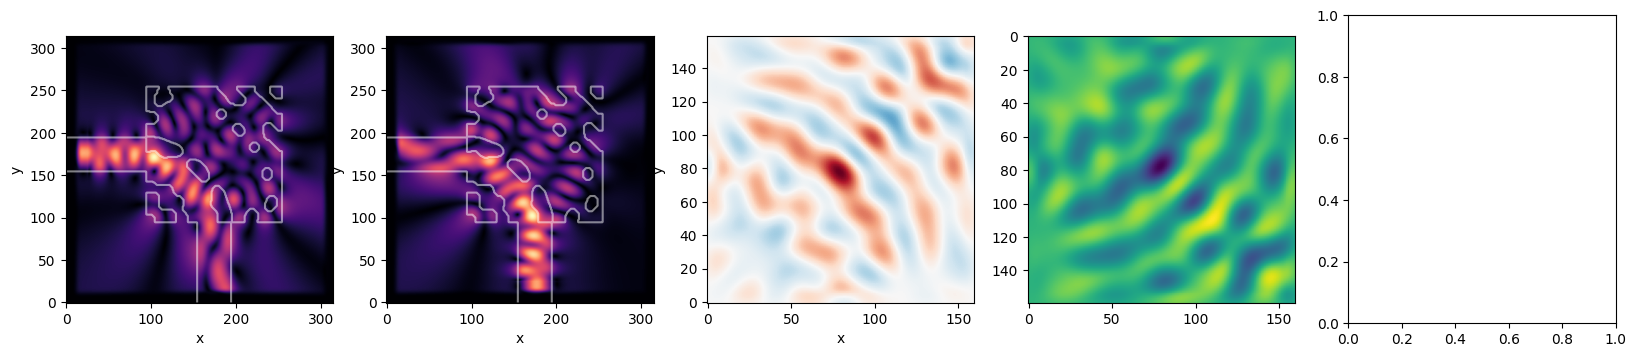

Step : 18 / 20
Loss : 30.303982
Max grad: 0.010982802
True


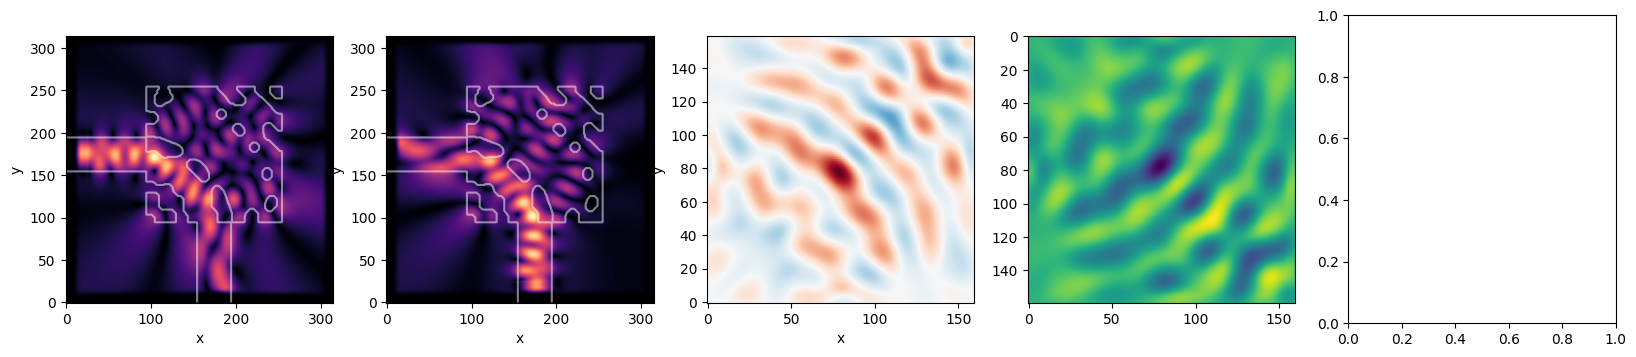

Step : 19 / 20
Loss : 28.032562
Max grad: 0.010194399
True


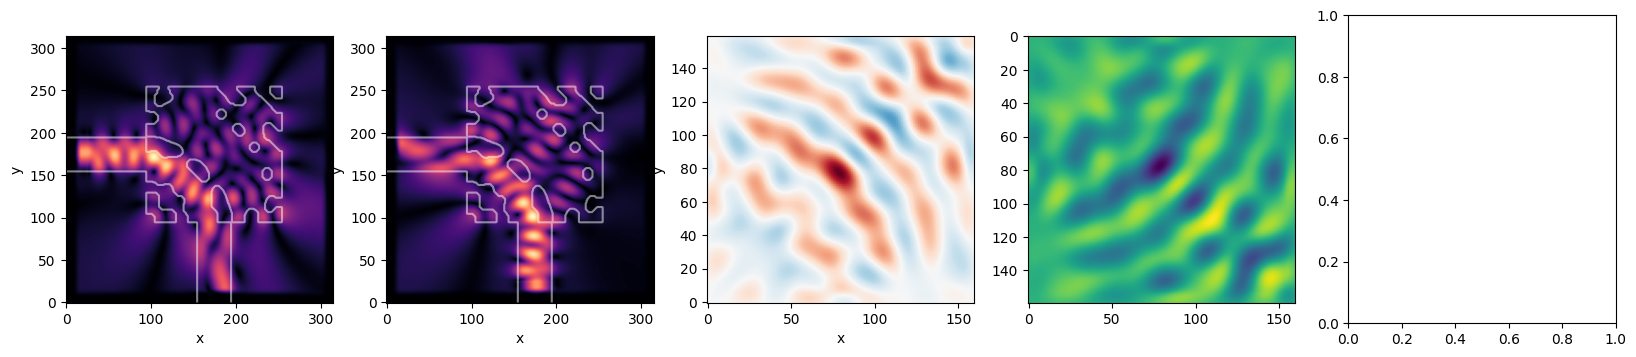

Step : 20 / 20
Loss : 26.6623
Max grad: 0.009499365


In [55]:
Nsteps = 20
step = 0
losses = np.ndarray(Nsteps)

#global debug
debug = True

range_ = trange(step, Nsteps)
for step in range_:
    loss, state = step_fn(step, state)
    losses[step] = loss
    range_.set_postfix(loss=float(loss))

In [ ]:
latent = params_fn(state)
design = forward(latent, brush, 1)
s_params, fields = model.simulate(design)
epsr = model.epsilon_r(design)
ceviche.viz.abs(np.squeeze(fields[0]), model.density(design))
plt.grid()

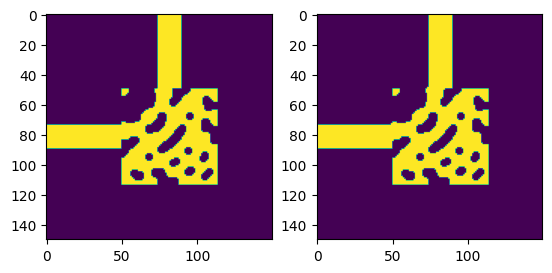

In [63]:
epsr = model.epsilon_r(design)
fig, ax = plt.subplots(1,2)
ax[0].imshow(epsr)
ax[1].imshow(erosion(dilation(epsr, brush), brush))

In [50]:
s11 = jnp.abs(s_params[:, 0, 0])**2
s21 = jnp.abs(s_params[:, 0, 1])**2

10*np.log10(s11), 10*np.log10(s21), 

(array([-14.021027, -12.773975, -11.904688], dtype=float32),
 array([-3.9356523, -4.3316784, -3.7397985], dtype=float32))

Text(0, 0.5, 'Normalized Loss')

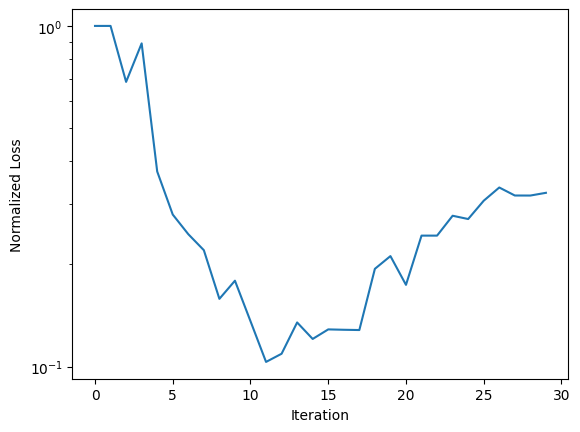

In [51]:
plt.plot(losses/max(losses))
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Normalized Loss")